# Supervised Learning Models

**Group 19**

*Cátia Antunes* (fc60494) - 5h  
*Donato Aveiro* (fc46269) -  
*Márcia Vital* (fc59488) -   
*Seán Gorman* (fc59492) -  

The goal of this first home assignment was to predict the critical temperature of a superconductor based on 81 extracted features.

In [20]:
# Importation of all modules required for the assignment
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor


In [21]:
# Data loading 
df1 = pd.read_csv("train.csv")

In [22]:
#One hot encoding for categorical variables
df1 = pd.get_dummies(df1, columns=['number_of_elements'])



In [23]:
df2 = pd.read_csv("unique_m.csv")
df2.drop("critical_temp", axis=1, inplace=True)
df2.drop("material", axis=1, inplace=True)

In [24]:
#merge the two dataframes on the row index
df1 = pd.merge(df1, df2, left_index=True, right_index=True)

We began our data preprocess by taking a look at the data types of each column in order to see if there were some miss-labeled data types and if there were missing values. Since there were no missing values detected, it was not necessary to do any missing value imputation. (Outputs not show in order to save space.)

In [25]:
# As there were two data types, int and float, all integers where converted to float in order to have only one data type
df1[['range_atomic_radius', 'range_Valence']] = df1[[ 'range_atomic_radius', 'range_Valence']].astype(float)

# Temperature sepparation
def critical_temp_sep(x):
    if x < 1.0:
        return 'VeryLow'
    elif x >= 1.0 and x < 5.0:
        return 'Low'
    elif x >= 5.0 and x < 20.0:
        return 'Medium'
    elif x >= 20.0 and x < 100.0:
        return 'High'
    else:
        return 'VeryHigh'
    
df1['critical_temp classes'] = df1['critical_temp'].apply(critical_temp_sep)

# With the critical_temp classes created, we can remove our classification and regression labels from our X dataset and store them in two separate datasets, y_clf and y_reg, for the classification and regression tasks, respectively. 
y_clf = df1['critical_temp classes']
y_reg = df1['critical_temp']
X = df1.drop(columns=['critical_temp', 'critical_temp classes'])


With the removal of the classification and regression labels, we can now split our data into train and test datasets. For the classification data, in order to account for unbalanced classes, the performed split was done with stratification to guarantee an even class distribution in both train and test sets. This is not a necessary step for the split of the regression data. For both cases, the data was split with a XXX ratio (10% for testing).

In [26]:
# Data split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, 
                     test_size=0.1,
                     stratify=y_clf,
                     random_state=1)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, 
                    test_size=0.1,
                    random_state=1)

print('Train: ', X_train_clf.shape)
print('Test: ', X_test_clf.shape)

Train:  (19136, 175)
Test:  (2127, 175)


With the datasets divided into training and testing, we next proceeded to scale the datasets. This step needs to be done after the train and test split to avoid that the data present on the test dataset influences the training data. This problem is solved by first splitting the training and test sets and then fitting the scaler with the training set. The test set will be transformed with the fit done with the training set.
The scaling itself is an important process since there are features in different scales that would influence the algorithms. The standardization consists of bringing the features into a mean of zero and a standard variation of one.

In [27]:
# Scaling of training data for classification
std_scaler = StandardScaler()
X_train_clf = std_scaler.fit_transform(X_train_clf)
X_train_clf = pd.DataFrame(X_train_clf, columns = X.columns)
#X_train_clf

# Scaling of test data for classification
X_test_clf = std_scaler.transform(X_test_clf)
X_test_clf = pd.DataFrame(X_test_clf, columns = X.columns)
#X_test_clf

# Scaling of training data for linear regression
std_scaler = StandardScaler()
X_train_reg = std_scaler.fit_transform(X_train_reg)
X_train_reg = pd.DataFrame(X_train_reg, columns = X.columns)
#X_train_reg

# Transformation of testing data 
X_test_reg = std_scaler.transform(X_test_reg)
X_test_reg = pd.DataFrame(X_test_reg, columns = X.columns)
#X_test_reg

PRINCIPAL COMPONENT ANALYSIS

Given the high number of features present in the data, a feature selection was necessary. This was achieved with Principal Component Analysis (PCA).

In [28]:
pca = PCA(n_components = 0.9)
X_train_clf_pca = pca.fit_transform(X_train_clf)
#X_train_clf

pca = PCA(n_components = 0.9)
X_train_reg_pca = pd.DataFrame(pca.fit_transform(X_train_reg))
#X_train_reg


W, v = np.linalg.eig(X_train_reg.T @ X_train_reg)
vexp = W/W.sum()

pca.fit(X_train_reg)
tve=0
for i, ve in enumerate(pca.explained_variance_ratio_):
    tve+=ve
    print("PC%d - Variance explained: %7.4f - Total Variance: %7.4f" % (i, ve, tve) )
print()
print("Actual Eigenvalues:", pca.singular_values_)
for i,comp in enumerate(pca.components_):
    print("PC",i, "-->", comp)


X_train_transf = X_train_reg @ v[:12,:].T
X_train_transf.shape

PC0 - Variance explained:  0.1993 - Total Variance:  0.1993
PC1 - Variance explained:  0.0558 - Total Variance:  0.2551
PC2 - Variance explained:  0.0520 - Total Variance:  0.3071
PC3 - Variance explained:  0.0413 - Total Variance:  0.3484
PC4 - Variance explained:  0.0321 - Total Variance:  0.3805
PC5 - Variance explained:  0.0218 - Total Variance:  0.4023
PC6 - Variance explained:  0.0204 - Total Variance:  0.4227
PC7 - Variance explained:  0.0179 - Total Variance:  0.4406
PC8 - Variance explained:  0.0158 - Total Variance:  0.4564
PC9 - Variance explained:  0.0156 - Total Variance:  0.4720
PC10 - Variance explained:  0.0137 - Total Variance:  0.4858
PC11 - Variance explained:  0.0129 - Total Variance:  0.4987
PC12 - Variance explained:  0.0119 - Total Variance:  0.5105
PC13 - Variance explained:  0.0110 - Total Variance:  0.5215
PC14 - Variance explained:  0.0108 - Total Variance:  0.5323
PC15 - Variance explained:  0.0104 - Total Variance:  0.5427
PC16 - Variance explained:  0.0101

(19136, 12)

In [29]:
X_test_transf = X_test_reg @ v[:12,:].T


LINEAR MODEL OF THE PCA 

By using a PCA, we can select a subset of principal components that capture most of the variation in the data, and use them as predictors in the regression model. This can help us avoid overfitting, multicollinearity, and noise issues that may arise from using too many or irrelevant features. Below is the linear regression of the projected data followed by a linear model of the full dataset for comparison.

In [30]:
''' Linear regression of the PCA projection '''

# associate data with the variables here
X = X_train_transf ##### Replace here with train
y = y_train_reg ##### Replace here with train

# Create and fit a linear regression model
model = linear_model.LinearRegression() # Create linear regression object
model.fit(X, y) # Train the model using the training sets

# Make predictions using the testing set
Superconduct_y_pred2 = model.predict(X_test_transf) ##### Replace here with test

# Evaluate the model performance
print("Coefficients:", model.coef_) # print the coefficients
print("Intercept:", model.intercept_) # print the intercept
print("Mean squared error:", mean_squared_error(y_test_reg, Superconduct_y_pred2)) # print the MSE on training data
#print("R2 score:", r2_score(y, model.predict(X))) # print the R2 score on training data


Coefficients: [-3.79968527  1.05679499 -4.12239173 -0.15820411 -7.01550543 -7.56668706
 -3.87748393 -7.68985033  2.2788279   3.28914701  1.82068517 -3.8743633 ]
Intercept: 34.43720114025919
Mean squared error: 908.1781330743285


Coefficients: [ 2.63548311e+01 -4.39909368e+01 -1.36512206e+01  2.90254166e+01
 -1.20618900e+01  2.17075866e+00  9.50021064e+00  3.28693276e+00
 -1.02500207e+01  1.40110554e+00  2.19075491e+01  2.60948849e+01
 -2.35926440e+01 -1.48430601e+01  1.99489518e+02  1.65533433e+01
  1.64881963e+01  3.64546859e+00 -5.23353689e+00 -9.00785013e+00
  3.19569451e+00  6.30396029e+01 -1.08063179e+01 -6.60408584e+01
  6.51136071e+01  9.33032558e+00  6.66286370e+00 -2.52076880e+00
 -6.64760308e+00 -2.38138502e+00 -1.76596636e+01  2.03114781e+01
  6.45436430e+00 -7.56372431e+00 -1.55655099e+00 -1.33259552e+00
 -4.78340911e+00 -1.90293043e+00  7.12640224e+00 -2.78238741e+00
 -2.33290482e-01  9.91589324e+00  2.90624221e+00 -1.23358070e+01
  2.39157070e+00 -5.25672785e+00 -1.85645692e+01 -2.20646338e+00
  2.30352335e+01 -9.00525789e+00  1.65088937e+01 -2.83098764e+01
 -1.06424300e+01  1.96975290e+01 -7.06850346e+00  9.67384459e+00
 -3.52476775e+00  6.98562496e+00 -8.11533280e+00  6.78929743e+00
 -1.9852382

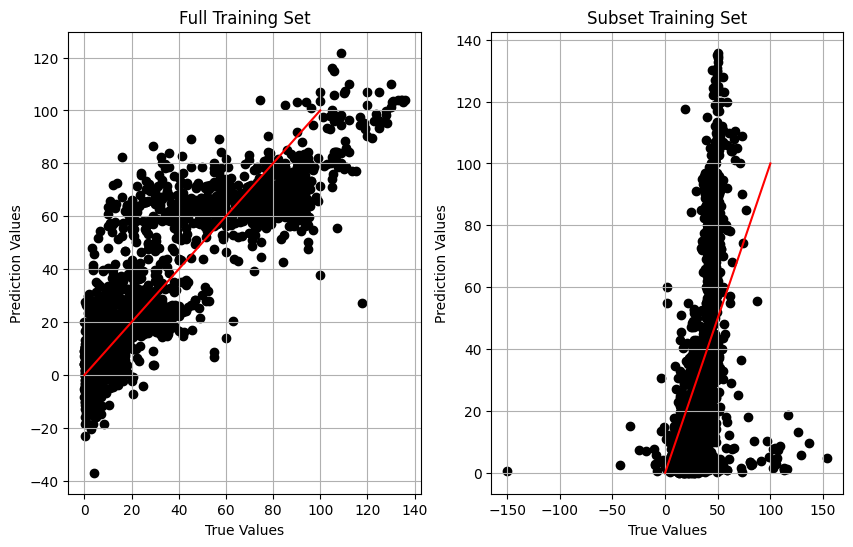

In [31]:
''' Linear regression of the full dataset '''


# associate data with the variables here
X = X_train_reg ##### Replace here with full clean data
y = y_train_reg ##### Replace here with full clean data

# Create and fit a linear regression model
model = linear_model.LinearRegression() # Create linear regression object
model.fit(X, y) # Train the model using the training sets 

# Make predictions using the testing set
Superconduct_y_pred = model.predict(X_test_reg) ##### Replace here with test  

# Evaluate the model performance
print("Coefficients:", model.coef_) # print the coefficients
print("Intercept:", model.intercept_) # print the intercept
print("Mean squared error:", mean_squared_error(y_test_reg, Superconduct_y_pred)) # print the MSE on training data
# print("R2 score:", r2_score((y_test_reg, Superconduct_y_pred))) # print the R2 score on training data

# Plot outputs
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test_reg, Superconduct_y_pred, color="black") 
# plt.plot(y_test_reg, Superconduct_y_pred, color="blue") 
plt.grid()
plt.plot([0, 100], [0, 100], c="r")
plt.title("Full Training Set")
plt.ylabel("Prediction Values")
plt.xlabel("True Values")

plt.subplot(1, 2, 2)
plt.scatter(Superconduct_y_pred2, y_test_reg, color="black", )
# plt.plot(Superconduct_y_pred, y_test_reg, color="blue")
plt.grid()
plt.plot([0, 100], [0, 100], c="r")
plt.title("Subset Training Set")
plt.ylabel("Prediction Values")
plt.xlabel("True Values")
plt.show()



In [33]:
def CreateRegPlots(y_test_reg, y_predict, X_test):
    fig = plt.figure(figsize=(6, 3))
    plt.scatter(y_test_reg, y_predict, color='green', alpha=0.2)
    plt.xlabel("Prediction Values")
    plt.ylabel("True Values")
    plt.plot([min(y_test_reg),max(y_test_reg)], [min(y_test_reg),max(y_test_reg)], linestyle="-", lw=1, color="k")
    plt.show()

Mean squared error: 156.1149012488694


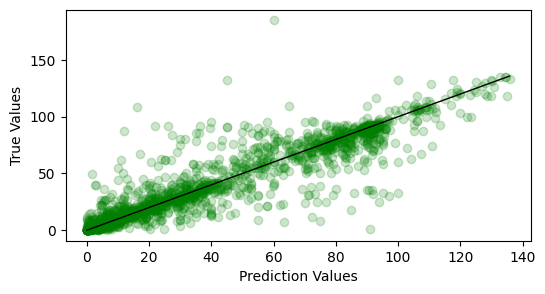

In [34]:
#Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# associate data with the variables here
X = X_train_reg ##### Replace here with full clean data
y = y_train_reg ##### Replace here with full clean data

# Create and fit a linear regression model
model = DecisionTreeRegressor() # Create linear regression object
model.fit(X, y) # Train the model using the training sets

# Make predictions using the testing set
Superconduct_y_pred = model.predict(X_test_reg) ##### Replace here with test

# Evaluate the model performance

print("Mean squared error:", mean_squared_error(y_test_reg, Superconduct_y_pred)) # print the MSE on training data
# print("R2 score:", r2_score((y_test_reg, Superconduct_y_pred))) # print the R2 score on training data

CreateRegPlots(y_test_reg, Superconduct_y_pred, X_test_reg)


Classifciation

In [35]:
vals, counts= np.unique(y_clf, return_counts=True)
print("0 - VeryLow, 1 - Low, 2 - Medium, 3 - High, 4 - VeryHigh")
for v, c in zip(vals, counts):
    print("# of ",v, "--->", c)

0 - VeryLow, 1 - Low, 2 - Medium, 3 - High, 4 - VeryHigh
# of  High ---> 9874
# of  Low ---> 4018
# of  Medium ---> 5568
# of  VeryHigh ---> 802
# of  VeryLow ---> 1001


In [37]:
# calculate the proportion of each class in the dataset
total_samples = 20563
class_very_low = 1036 / total_samples
class_low = 4057 / total_samples
class_medium = 5623 / total_samples
class_high = 9779 / total_samples
class_very_high = 768 / total_samples

# set the prior probabilities for each class
prior_sum = class_very_low + class_low + class_medium + class_high + class_very_high
class_prior = [class_very_low/prior_sum, class_low/prior_sum, class_medium/prior_sum, 
               class_high/prior_sum, class_very_high/prior_sum]

In [38]:
#import decision tree and naive bayes
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#initialize the models
dt = DecisionTreeClassifier()
nb = GaussianNB()
nb_prior = GaussianNB(priors=class_prior)


#fit the models
dt.fit(X_train_clf, y_train_clf)
nb.fit(X_train_clf, y_train_clf)
nb_prior.fit(X_train_clf, y_train_clf)


#predict the values
y_pred_dt = dt.predict(X_test_clf)
y_pred_nb = nb.predict(X_test_clf)
y_pred_nb_prior = nb_prior.predict(X_test_clf)

In [40]:
#check the accuracy of the models
from sklearn.metrics import accuracy_score

print("Decision Tree Accuracy: ", accuracy_score(y_test_clf, y_pred_dt))
print("Naive Bayes Accuracy: ", accuracy_score(y_test_clf, y_pred_nb))
print("Naive Bayes Accuracy with Prior: ", accuracy_score(y_test_clf, y_pred_nb_prior))

Decision Tree Accuracy:  0.8279266572637518
Naive Bayes Accuracy:  0.3732957216737188
Naive Bayes Accuracy with Prior:  0.3728255759285378


In [ ]:
#hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, 25, 35, 50],
    'min_samples_split': [1, 2, 5, 20, 30],
    'min_samples_leaf': [1, 2, 5, 10]
}

grid_search = GridSearchCV(estimator = dt, param_grid = param_grid,
                            cv = 3, n_jobs = -1, verbose = 0)

grid_search.fit(X_train_clf, y_train_clf)

grid_search.best_params_

#predict the values
y_pred_dt = grid_search.predict(X_test_clf)

#check the accuracy of the models
print("Decision Tree Accuracy: ", accuracy_score(y_test_clf, y_pred_dt))

In [ ]:
grid_search.best_params_

<Axes: >

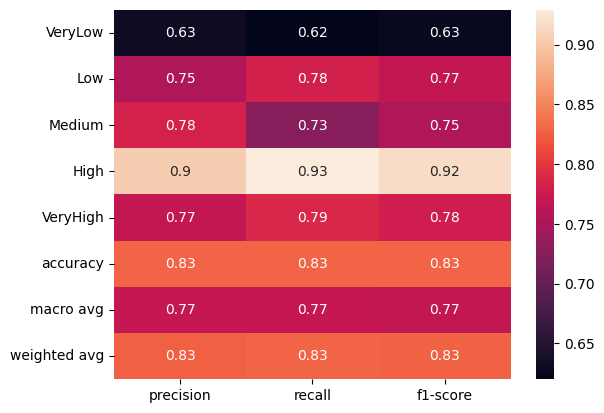

In [41]:
from sklearn.metrics import classification_report

labels = ['VeryLow', 'Low', 'Medium', 'High', 'VeryHigh']
report = pd.DataFrame(classification_report(y_test_clf, y_pred_dt, output_dict=True, labels=labels)).transpose()
import seaborn as sns
# .iloc[:-1, :] to exclude support
hm = sns.heatmap(report.iloc[:, :-1], annot=True)
hm

In [42]:
report

,precision,recall,f1-score,support
VeryLow,0.632653,0.620000,0.626263,100.000000
Low,0.754808,0.781095,0.767726,402.000000
Medium,0.782946,0.725314,0.753029,557.000000
High,0.904433,0.929150,0.916625,988.000000
VeryHigh,0.768293,0.787500,0.777778,80.000000
accuracy,0.827927,0.827927,0.827927,0.827927
macro avg,0.768627,0.768612,0.768284,2127.000000
weighted avg,0.826442,0.827927,0.826769,2127.000000


**DISCUSSION**


bla bla, I wish I knew